## Import du dataset et division en données normales / anormales 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [2]:
# Vérifier si TensorFlow détecte un GPU
if tf.config.list_physical_devices('GPU'):
    print("Il y a un GPU prêt à être utilisé.") 
else:
    print("Aucun GPU n'est disponible.")

Il y a un GPU prêt à être utilisé.


In [3]:
import pandas as pd
import glob
import os

# Chemin vers le dossier contenant les fichiers .h5
dataset_path = "./Dataset"

# Liste de tous les fichiers .h5 dans le dossier
h5_files = glob.glob(os.path.join(dataset_path, "*.h5"))

# Listes pour stocker les DataFrames normaux et anormaux
normal_data_frames = []
anomaly_data_frames = []

# Charger chaque fichier .h5 dans un DataFrame et le classer
for file in h5_files:
    try:
        df = pd.read_hdf(file)
        
        # Identifier les fichiers anormaux par la présence de mots-clés dans le nom du fichier
        if "shift_on" in file:
            anomaly_data_frames.append(df)
            print(f"{file} classé comme anomalie.")
        else:
            normal_data_frames.append(df)
            print(f"{file} classé comme normal.")
            
    except Exception as e:
        print(f"Erreur lors du chargement de {file}: {e}")


./Dataset\TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001_shift_on___flight_director_pitch__flight_director_roll.h5 classé comme anomalie.
./Dataset\TimeSeries_Scenario_00002_ScenarioInstanceRandint_id_0002.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00003_ScenarioInstanceRandint_id_0003.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00004_ScenarioInstanceRandint_id_0004.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00005_ScenarioInstanceRandint_id_0005.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006_shift_on___flight_director_pitch__flight_director_roll.h5 classé comme anomalie.
./Dataset\TimeSeries_Scenario_00007_ScenarioInstanceRandint_id_0007.h5 classé comme normal.
./Dataset\TimeSeries_Scenario_00008_ScenarioInstanceRandin

In [4]:
# Calcul du pourcentage de données normales et anormales
total_files = len(h5_files)
normal_percentage = (len(normal_data_frames) / total_files) * 100 if total_files > 0 else 0
anomaly_percentage = (len(anomaly_data_frames) / total_files) * 100 if total_files > 0 else 0

# Afficher les pourcentages
print(f"Pourcentage de données normales : {normal_percentage:.2f}%")
print(f"Pourcentage de données anormales : {anomaly_percentage:.2f}%")

#nbr de séries temporelles normales 
print(len(normal_data_frames))
print(len(anomaly_data_frames))


Pourcentage de données normales : 96.35%
Pourcentage de données anormales : 3.65%
949
36


In [5]:
def check_dataframe_sizes(dataframes):
    """
    Vérifie les tailles des DataFrames dans une liste.

    Paramètres:
    - dataframes (list): Liste contenant des DataFrames pandas.

    Retourne:
    - dict: Un dictionnaire où les clés sont les tailles (shape) et les valeurs sont 
            les indices des DataFrames correspondants.
    """
    size_dict = {}
    for i, df in enumerate(dataframes):
        size = df.shape
        if size not in size_dict:
            size_dict[size] = []
        size_dict[size].append(i)
    return size_dict

In [6]:
# Affichage des tailles de DataFrame
print("Tailles des DataFrames dans normal_data_frames:")
normal_data_sizes = check_dataframe_sizes(normal_data_frames)
for size, indices in normal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

Tailles des DataFrames dans normal_data_frames:
Taille (3582, 135): 559 simulations
Taille (3583, 135): 341 simulations
Taille (3584, 135): 35 simulations
Taille (3581, 135): 13 simulations
Taille (3585, 135): 1 simulations


In [7]:
print("Tailles des DataFrames dans anomaly_data_frames:")
anormal_data_sizes = check_dataframe_sizes(anomaly_data_frames)
for size, indices in anormal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

Tailles des DataFrames dans anomaly_data_frames:
Taille (3582, 137): 21 simulations
Taille (3583, 137): 15 simulations


In [8]:
# Uniformiser toutes les tailles des DataFrames à (3581, 135)
for i in range(len(normal_data_frames)):
    if normal_data_frames[i].shape[0] > 3581:
        # Supprimer les lignes excédentaires à partir de la fin
        normal_data_frames[i] = normal_data_frames[i].iloc[:3581, :]

for i in range(len(anomaly_data_frames)):
    if anomaly_data_frames[i].shape[0] > 3581:
        # Supprimer les lignes excédentaires à partir de la fin
        anomaly_data_frames[i] = anomaly_data_frames[i].iloc[:3581, :]

In [9]:
# Affichage des tailles après l'ajustement
print("Tailles des DataFrames dans normal_data_frames après l'ajustement:")
normal_data_sizes = check_dataframe_sizes(normal_data_frames)
for size, indices in normal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

print("Tailles des DataFrames dans anomaly_data_frames après l'ajustement:")
anormal_data_sizes = check_dataframe_sizes(anomaly_data_frames)
for size, indices in anormal_data_sizes.items():
    print(f"Taille {size}: {len(indices)} simulations")

Tailles des DataFrames dans normal_data_frames après l'ajustement:
Taille (3581, 135): 949 simulations
Tailles des DataFrames dans anomaly_data_frames après l'ajustement:
Taille (3581, 137): 36 simulations


### 1. Prise en main des données et préparation à l'entrainement. 

### Identifier les colonnes anomalies 

In [10]:
# Comparer les colonnes des DataFrames
def identifier_nouvelles_colonnes(normal_data, anormal_data):
    # Identifier les colonnes qui sont dans anormal_data mais pas dans normal_data
    normal_columns = set(normal_data.columns)
    anormal_columns = set(anormal_data.columns)
    
    nouvelles_colonnes = anormal_columns - normal_columns  # Colonnes présentes dans anormal_data mais pas dans normal_data
    
    print(f"Nombre de nouvelles colonnes dans 'anormal_data' : {len(nouvelles_colonnes)}")
    print(f"Colonnes nouvelles dans 'anormal_data' : {nouvelles_colonnes}")
    
    return nouvelles_colonnes

# Exemple d'appel
nouvelles_colonnes = identifier_nouvelles_colonnes(normal_data_frames[0], anomaly_data_frames[0])

Nombre de nouvelles colonnes dans 'anormal_data' : 2
Colonnes nouvelles dans 'anormal_data' : {'sim/cockpit/autopilot/flight_director_roll_ground_truth', 'sim/cockpit/autopilot/flight_director_pitch_ground_truth'}


In [11]:
columns_anomalies = [
    'sim/cockpit/autopilot/flight_director_pitch',
    'sim/cockpit/autopilot/flight_director_roll'
]
columns_ground_truth = [
        'sim/cockpit/autopilot/flight_director_pitch_ground_truth',
    'sim/cockpit/autopilot/flight_director_roll_ground_truth'
]

### Affichage du paramètre présentant l'anomalie vs le normal

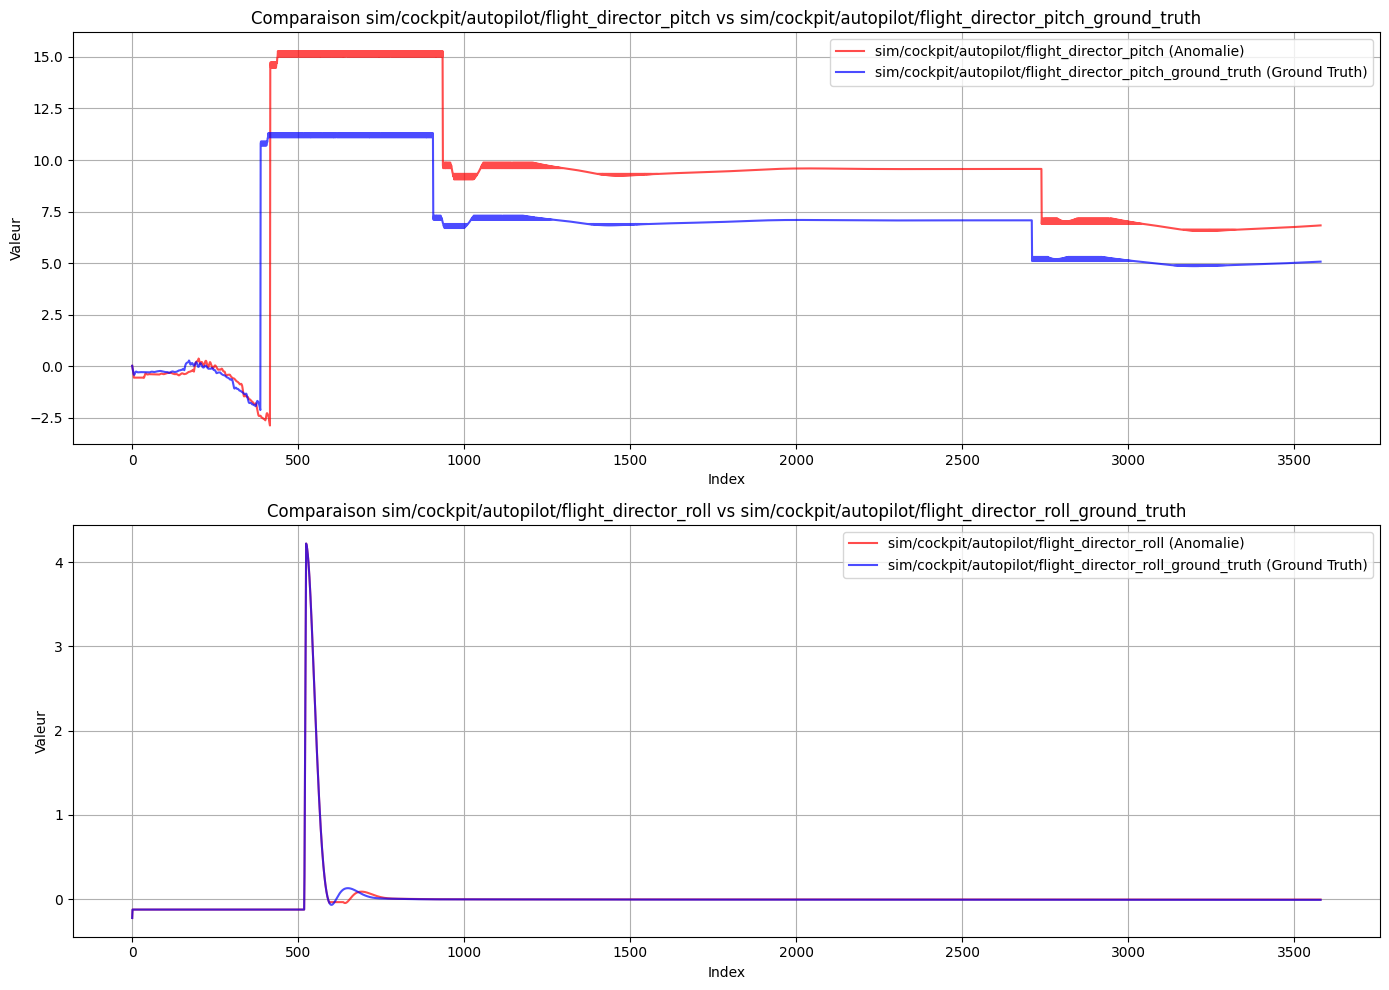

In [12]:
def afficher_comparaison_variables(data, variables_anomalie, variables_ground_truth):
    """
    Affiche les courbes pour comparer les variables anomalies et les variables ground truth.

    Paramètres:
    - data: Données contenant les variables à comparer (DataFrame).
    - variables_anomalie: Liste des noms des variables anomalies.
    - variables_ground_truth: Liste des noms des variables ground truth.
    """
    plt.figure(figsize=(14, 5 * len(variables_anomalie)))

    # Parcourir chaque paire de variables
    for i, (anomalie_var, ground_truth_var) in enumerate(zip(variables_anomalie, variables_ground_truth)):
        plt.subplot(len(variables_anomalie), 1, i + 1)
        plt.plot(data[anomalie_var], label=f'{anomalie_var} (Anomalie)', color='red', alpha=0.7)
        plt.plot(data[ground_truth_var], label=f'{ground_truth_var} (Ground Truth)', color='blue', alpha=0.7)
        plt.title(f"Comparaison {anomalie_var} vs {ground_truth_var}")
        plt.legend()
        plt.xlabel("Index")
        plt.ylabel("Valeur")
        plt.grid()

    plt.tight_layout()
    plt.show()

# Exemple d'appel de la fonction
afficher_comparaison_variables(
    anomaly_data_frames[0],  # Simulation spécifique
    columns_anomalies,  # Variables anomalies
    columns_ground_truth  # Variables ground truth
)

### Préparation des données

In [13]:
# Diviser les données normales en ensemble d'entraînement (80%) et ensemble de test (20%)
train_normal, test_normal = train_test_split(normal_data_frames, test_size=0.2, random_state=42)


In [14]:
# Fonction pour normaliser et convertir les DataFrames en tableau numpy
def prepare_data(dataframes):
    """
    Prépare les données pour le modèle LSTM:
    - Convertit les DataFrames en tableaux numpy.
    - Normalise les valeurs avec StandardScaler.

    Paramètres:
    - dataframes (list): Liste de DataFrames.

    Retourne:
    - numpy.array: Données normalisées sous forme de tableau numpy.
    """
    scaler = StandardScaler()
    # Convertir les DataFrames en tableau numpy et normaliser
    data_array = [df.values for df in dataframes]
    data_array = np.array([scaler.fit_transform(simulation) for simulation in data_array])
    return np.array(data_array)

# Normalisation et conversion des données
train_normal_data = prepare_data(train_normal)
test_normal_data = prepare_data(test_normal)
anomaly_data = prepare_data(anomaly_data_frames)


print(f"Taille des données d'entraînement: {train_normal_data.shape}")
print(f"Taille des données de test (normal): {test_normal_data.shape}")
print(f"Taille des données anormal: {anomaly_data.shape}")


Taille des données d'entraînement: (759, 3581, 135)
Taille des données de test (normal): (190, 3581, 135)
Taille des données anormal: (36, 3581, 137)


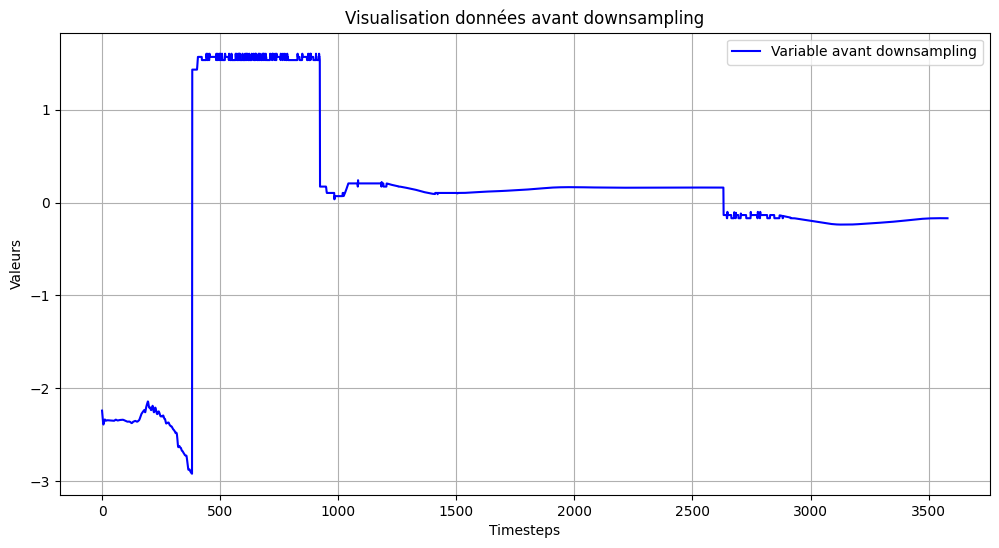

In [15]:
# Créer un axe de temps (0 à 3581)
timesteps = range(train_normal_data.shape[1])

# Tracer les données
plt.figure(figsize=(12, 6))
plt.plot(timesteps, train_normal_data[0, :, 0], label="Variable avant downsampling", color='b')
plt.title("Visualisation données avant downsampling")
plt.xlabel("Timesteps")
plt.ylabel("Valeurs")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Fonction pour effectuer le downsampling des données
def downsample(data, factor=10):
    """
    Réduit le nombre d'étapes temporelles en gardant chaque `factor`-ème étape.

    Paramètres:
    - data (numpy.array): Tableau de données avec la forme (samples, timesteps, features).
    - factor (int): Facteur de downsampling (par défaut 3).

    Retourne:
    - numpy.array: Données après downsampling.
    """
    return data[:, ::factor, :]  # Garder chaque `factor`-ème étape

In [17]:
# Appliquer le downsampling aux données normalisées et renommer les variables
train_normal_data_reduced = downsample(train_normal_data)
test_normal_data_reduced = downsample(test_normal_data)
anomaly_data_reduced = downsample(anomaly_data)

# Affichage des tailles des données après préparation et downsampling
print(f"Taille des données d'entraînement réduites: {train_normal_data_reduced.shape}")
print(f"Taille des données de test normales réduites: {test_normal_data_reduced.shape}")
print(f"Taille des données anormales réduites: {anomaly_data_reduced.shape}")

Taille des données d'entraînement réduites: (759, 359, 135)
Taille des données de test normales réduites: (190, 359, 135)
Taille des données anormales réduites: (36, 359, 137)


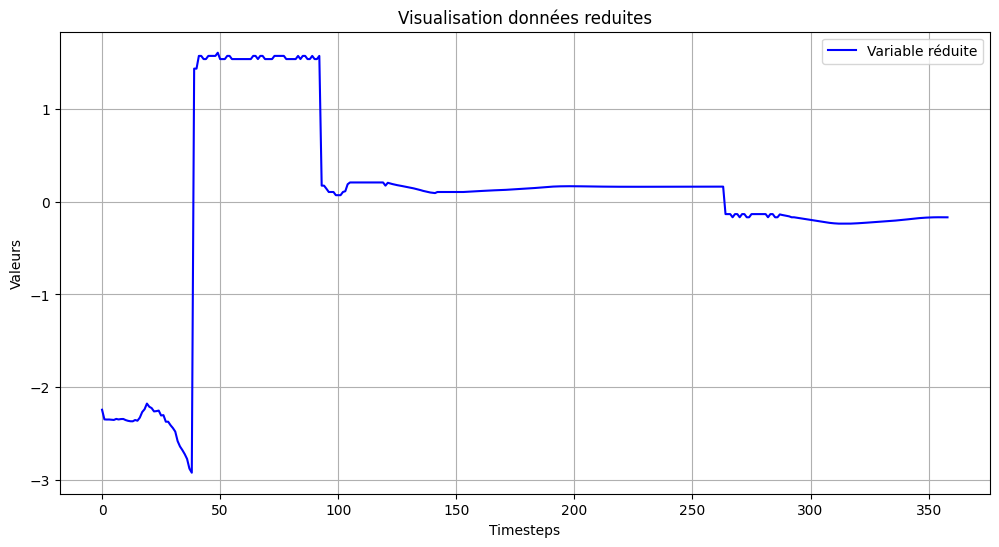

In [18]:
timesteps = range(train_normal_data_reduced.shape[1])

# Tracer les données
plt.figure(figsize=(12, 6))
plt.plot(timesteps, train_normal_data_reduced[0, :, 0], label="Variable réduite", color='b')
plt.title("Visualisation données reduites")
plt.xlabel("Timesteps")
plt.ylabel("Valeurs")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Séparer les données anormales en deux parties : données normales et ground truth
def split_anomalous_data(data, ground_truth_columns):
    """
    Sépare les données anormales en deux parties :
    - Données normales (135 colonnes).
    - Ground truth (2 colonnes).

    Paramètres:
    - data (numpy.array): Données anormales après préparation (shape: samples, timesteps, features).
    - ground_truth_columns (list): Indices des colonnes ground truth.

    Retourne:
    - tuple: (données normales, ground truth).
    """
    normal_features = np.delete(data, ground_truth_columns, axis=2)
    ground_truth = data[:, :, ground_truth_columns]
    return normal_features, ground_truth

# Définir les indices des colonnes ground truth
ground_truth_indices = [135, 136]  # Indices des colonnes ground truth (les deux dernières colonnes)

# Appliquer la séparation
anomaly_data_reduced_normal, anomaly_data_ground_truth = split_anomalous_data(anomaly_data_reduced, ground_truth_indices)

print(f"Taille des données anormales normales: {anomaly_data_reduced_normal.shape}")
print(f"Taille des ground truths: {anomaly_data_ground_truth.shape}")

Taille des données anormales normales: (36, 359, 135)
Taille des ground truths: (36, 359, 2)


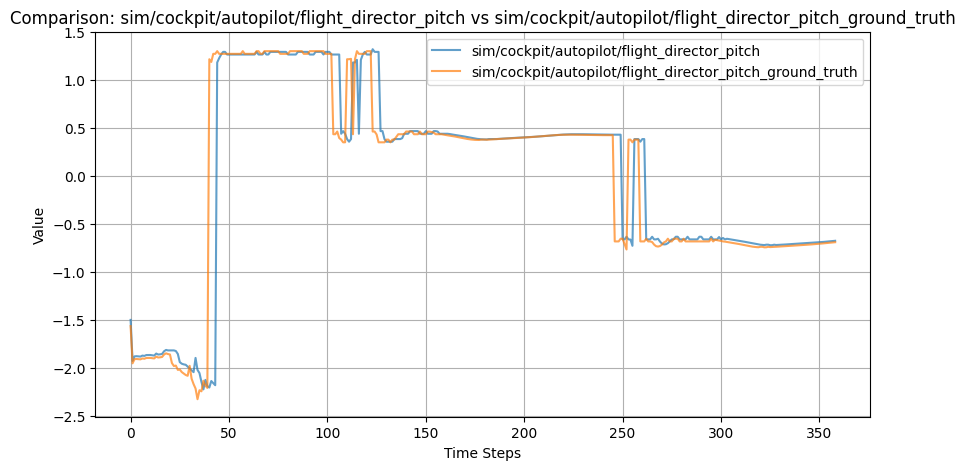

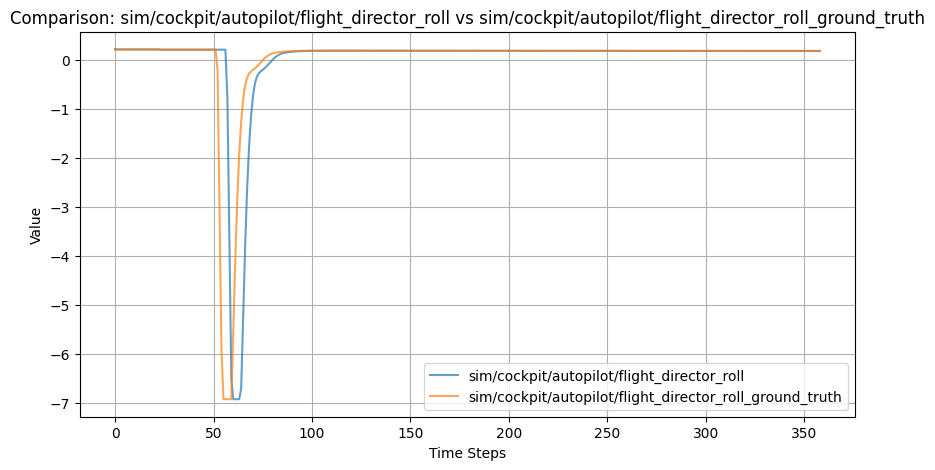

In [21]:
# Fonction pour tracer les comparaisons entre les variables et leurs ground truths
def plot_comparison(anomalous_data, ground_truth, feature_names, ground_truth_names, sample_index=0):
    """
    Trace les comparaisons entre les données anormales et leurs ground truths.

    Paramètres:
    - anomalous_data (numpy.array): Données anormales (samples, timesteps, features).
    - ground_truth (numpy.array): Ground truths correspondants (samples, timesteps, 2).
    - feature_names (list): Noms des variables à tracer.
    - ground_truth_names (list): Noms des ground truths.
    - sample_index (int): Index de l'échantillon à tracer.
    """
    time_steps = np.arange(anomalous_data.shape[1])

    for i, feature_name in enumerate(feature_names):
        plt.figure(figsize=(10, 5))
        plt.plot(time_steps, anomalous_data[sample_index, :, i], label=f"{feature_name}", alpha=0.7)
        plt.plot(time_steps, ground_truth[sample_index, :, i], label=f"{ground_truth_names[i]}", alpha=0.7)
        plt.xlabel("Time Steps")
        plt.ylabel("Value")
        plt.title(f"Comparison: {feature_name} vs {ground_truth_names[i]}")
        plt.legend()
        plt.grid(True)
        plt.show()


# Tracer les comparaisons pour le premier échantillon
plot_comparison(anomaly_data_reduced_normal, anomaly_data_ground_truth, columns_anomalies, columns_ground_truth, sample_index=34)

### Construction du modèle LSTM Autoencoder

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# Dimensions des données
timesteps = train_normal_data_reduced.shape[1]  # Nombre d'étapes temporelles
input_dim = train_normal_data_reduced.shape[2]  # Nombre de variables (features)

# Définir l'architecture du modèle LSTM Autoencoder
inputs = Input(shape=(timesteps, input_dim))

# Encoder: LSTM Layers avec Regularization et Dropout
encoded = LSTM(512, activation='tanh', return_sequences=True)(inputs)
#encoded = Dropout(0.2)(encoded)
encoded = LSTM(256, activation='tanh', return_sequences=False)(encoded)

# Bottleneck (espace latent)
bottleneck = Dense(128, activation='relu')(encoded)

# Decoder: LSTM Layers
decoded = RepeatVector(timesteps)(bottleneck)
decoded = LSTM(256, activation='tanh', return_sequences=True)(decoded)
#decoded = Dropout(0.2)(decoded)
decoded = LSTM(512, activation='tanh', return_sequences=True)(decoded)

# Sortie: TimeDistributed(Dense(input_dim)) pour reconstruire les données
outputs = TimeDistributed(Dense(input_dim))(decoded)

In [24]:
# Compile the model
autoencoder = tf.keras.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')

In [25]:
# Afficher la structure du modèle
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 359, 135)]        0         
                                                                 
 lstm (LSTM)                 (None, 359, 512)          1327104   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 repeat_vector (RepeatVector  (None, 359, 128)         0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 359, 256)          394240    
                                                             

In [26]:
history = autoencoder.fit(
    train_normal_data_reduced, 
    train_normal_data_reduced,  # Les données normales pour l'entraînement
    epochs=50, 
    batch_size=32, 
    validation_split=0.2
)

Epoch 1/50
19/19 [==============================] - 12s 265ms/step - loss: 0.9365 - val_loss: 0.8908
Epoch 2/50
19/19 [==============================] - 4s 205ms/step - loss: 0.9551 - val_loss: 1.0783
Epoch 3/50
19/19 [==============================] - 4s 196ms/step - loss: 0.9478 - val_loss: 0.9197
Epoch 4/50
19/19 [==============================] - 4s 204ms/step - loss: 0.9570 - val_loss: 0.9355
Epoch 5/50
19/19 [==============================] - 4s 199ms/step - loss: 0.9306 - val_loss: 0.9109
Epoch 6/50
19/19 [==============================] - 4s 196ms/step - loss: 0.9510 - val_loss: 0.8998
Epoch 7/50
19/19 [==============================] - 4s 198ms/step - loss: 0.8732 - val_loss: 0.8013
Epoch 8/50
19/19 [==============================] - 4s 211ms/step - loss: 0.6325 - val_loss: 0.5040
Epoch 9/50
19/19 [==============================] - 4s 208ms/step - loss: 0.4595 - val_loss: 0.4203
Epoch 10/50
19/19 [==============================] - 4s 206ms/step - loss: 0.4061 - val_loss: 0.387

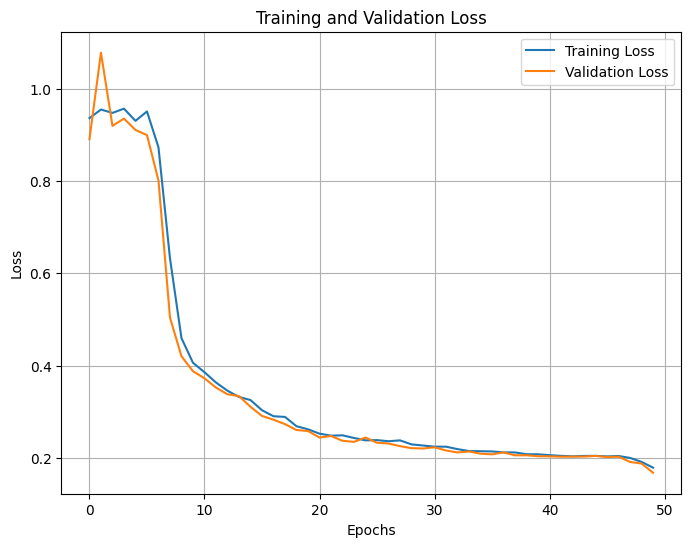

In [27]:
# Tracer la courbe de la loss
def plot_and_save_loss(history, filename='loss_plot.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)  # Enregistrer le graphe
    plt.show()

# Après l'entraînement
plot_and_save_loss(history)

In [28]:
# Sauvegarder le modèle après l'entraînement
autoencoder.save('lstm_autoencoder_model.h5')  # Sauvegarder le modèle dans un fichier .h5
print("Modèle enregistré avec succès")

Modèle enregistré avec succès


In [53]:
# Charger le modèle après l'entraînement
autoencoder_loaded = tf.keras.models.load_model('lstm_autoencoder_model.h5')  # Charger le modèle sauvegardé

# Vérifier la structure du modèle chargé
autoencoder_loaded.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 359, 135)]        0         
                                                                 
 lstm (LSTM)                 (None, 359, 512)          1327104   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 repeat_vector (RepeatVector  (None, 359, 128)         0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 359, 256)          394240    
                                                             

In [54]:
# Reconstruction des données anomalies avec le modèle
reconstructed_anomaly_data = autoencoder_loaded.predict(anomaly_data_reduced_normal)

2/2 [==============================] - 2s 56ms/step


In [55]:
print("Taille des données anomalies originales (test_anomaly_data_reduced):", anomaly_data_reduced_normal.shape)
print("Taille des données reconstruites (reconstructed_anomaly_data):", reconstructed_anomaly_data.shape)
print("Taille des données ground truth (ground_truth_data_reduced):", anomaly_data_ground_truth.shape)


Taille des données anomalies originales (test_anomaly_data_reduced): (36, 359, 135)
Taille des données reconstruites (reconstructed_anomaly_data): (36, 359, 135)
Taille des données ground truth (ground_truth_data_reduced): (36, 359, 2)


In [56]:
# Fonction pour tracer les comparaisons entre les données originales, ground truths et les données reconstruites
def plot_comparison_with_reconstructed(anomalous_data, ground_truth, reconstructed_data, feature_names, ground_truth_names, sample_index=0):
    """
    Trace les comparaisons entre les données originales, leurs ground truths et les reconstructions.

    Paramètres:
    - anomalous_data (numpy.array): Données anormales originales (samples, timesteps, features).
    - ground_truth (numpy.array): Ground truths correspondants (samples, timesteps, 2).
    - reconstructed_data (numpy.array): Données reconstruites par le modèle (samples, timesteps, features).
    - feature_names (list): Noms des variables à tracer.
    - ground_truth_names (list): Noms des ground truths.
    - sample_index (int): Index de l'échantillon à tracer.
    """
    time_steps = np.arange(anomalous_data.shape[1])

    for i, feature_name in enumerate(feature_names):
        plt.figure(figsize=(10, 5))
        # Données originales
        plt.plot(time_steps, anomalous_data[sample_index, :, i], label=f"{feature_name} (Anomalous)", alpha=0.7)
        # Ground truths
        plt.plot(time_steps, ground_truth[sample_index, :, i], label=f"{ground_truth_names[i]} (Ground Truth)", alpha=0.7)
        # Données reconstruites
        plt.plot(time_steps, reconstructed_data[sample_index, :, i], label=f"{feature_name} (Reconstructed)", linestyle='dashed')

        plt.xlabel("Time Steps")
        plt.ylabel("Value")
        plt.title(f"Comparison: {feature_name}, Ground Truth, and Reconstructed")
        plt.legend()
        plt.grid(True)
        plt.show()

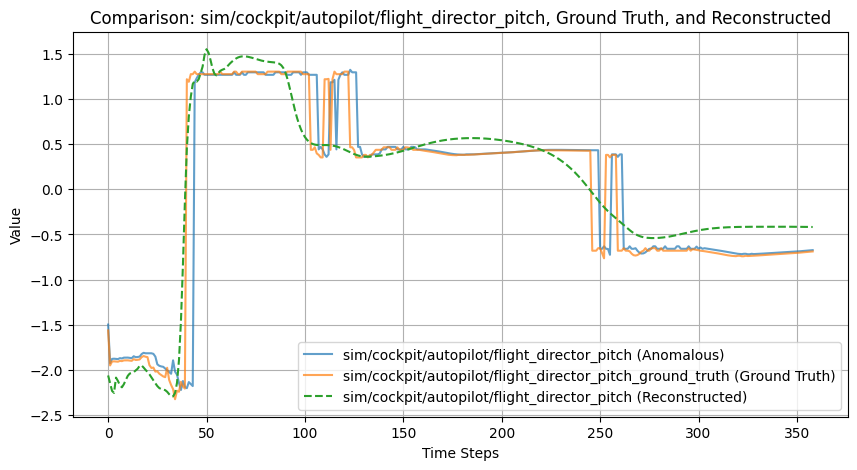

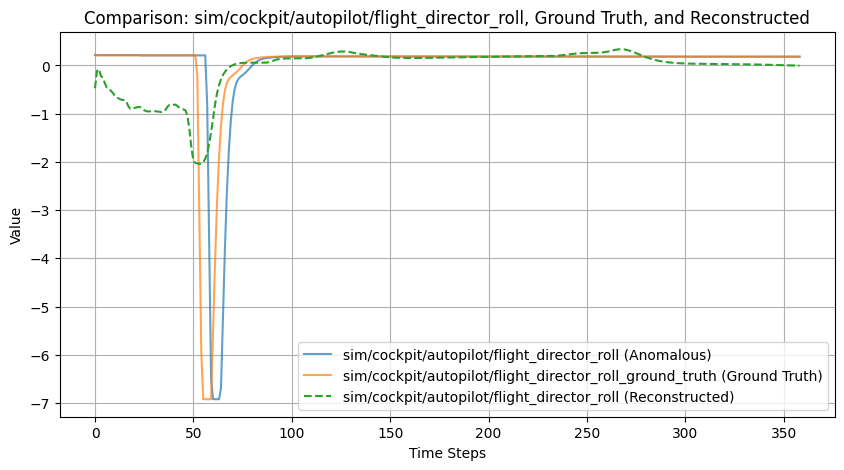

In [57]:
# Tracer les comparaisons pour le premier échantillon
plot_comparison_with_reconstructed(
    anomaly_data_reduced_normal, 
    anomaly_data_ground_truth, 
    reconstructed_anomaly_data, 
    columns_anomalies, 
    columns_ground_truth, 
    sample_index=34  # Changer l'index pour examiner d'autres exemples
)

### Détection des anomalies

In [34]:
# Calculer l'erreur de reconstruction pour les données normales (train data)
reconstructed_normal = autoencoder_loaded.predict(train_normal_data_reduced)
mse_normal = np.mean(np.square(train_normal_data_reduced - reconstructed_normal), axis=(1, 2))

24/24 [==============================] - 2s 72ms/step


In [36]:
# Déterminer un seuil pour détecter les anomalies à partir des données normales
threshold = np.percentile(mse_normal, 95)  # Utiliser le percentile 95 de l'erreur pour le seuil
print(f"Seuil de détection des anomalies basé sur les données normales: {threshold}")

Seuil de détection des anomalies basé sur les données normales: 0.27096015253590483


In [37]:
# Calculer l'erreur de reconstruction pour les données de test normales
reconstructed_test_normal = autoencoder_loaded.predict(test_normal_data_reduced)
mse_test_normal = np.mean(np.square(test_normal_data_reduced - reconstructed_test_normal), axis=(1, 2))

# Calculer l'erreur de reconstruction pour les données anormales
reconstructed_anomalies = autoencoder_loaded.predict(anomaly_data_reduced_normal)
mse_anomalies = np.mean(np.square(anomaly_data_reduced_normal - reconstructed_anomalies), axis=(1, 2))

# Détection des anomalies: Comparer l'erreur de reconstruction avec le seuil
anomalies = mse_anomalies > threshold  # Si l'erreur de reconstruction est plus grande que le seuil, c'est une anomalie
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

2/2 [==============================] - 0s 57ms/step
Nombre d'anomalies détectées: 2


### LSTM Unet Auto-encoder

In [153]:
# Dimensions des données
timesteps = train_normal_data_reduced.shape[1]  # Nombre d'étapes temporelles
input_dim = train_normal_data_reduced.shape[2]  # Nombre de variables (features)

# Définir l'architecture du modèle LSTM Autoencoder avec Unet
inputs = Input(shape=(timesteps, input_dim))

# Encoder: LSTM Layers
encoded1 = LSTM(512, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
encoded2 = LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(encoded1)
encoded3 = LSTM(128, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.001))(encoded2)

# Bottleneck (espace latent)
bottleneck = Dense(64, activation='relu')(encoded3)

# Decoder: LSTM Layers
decoded1 = RepeatVector(timesteps)(bottleneck)
decoded2 = LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded1)
decoded2 = concatenate([decoded2, encoded2])  # Skip connection from encoder layer 2
decoded3 = LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded2)
decoded3 = concatenate([decoded3, encoded1])  # Skip connection from encoder layer 1
decoded4 = LSTM(512, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded3)

# Sortie: TimeDistributed(Dense(input_dim)) pour reconstruire les données
outputs = TimeDistributed(Dense(input_dim))(decoded4)

# Compile the model
autoencoder_unet = Model(inputs, outputs)
autoencoder_unet.compile(optimizer='adam', loss='mse')  # Utilisation de MSE comme fonction de perte

In [154]:
# Afficher la structure du modèle
autoencoder_unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 359, 135)]   0           []                               
                                                                                                  
 lstm_14 (LSTM)                 (None, 359, 512)     1327104     ['input_5[0][0]']                
                                                                                                  
 lstm_15 (LSTM)                 (None, 359, 256)     787456      ['lstm_14[0][0]']                
                                                                                                  
 lstm_16 (LSTM)                 (None, 128)          197120      ['lstm_15[0][0]']                
                                                                                            

In [155]:
# Early stopping pour arrêter l'entraînement si la perte de validation ne s'améliore pas
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraîner le modèle
history = autoencoder_unet.fit(
    train_normal_data_reduced, 
    train_normal_data_reduced,  # Les données normales pour l'entraînement
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/50
19/19 [==============================] - 13s 383ms/step - loss: 2.5319 - val_loss: 1.5176
Epoch 2/50
19/19 [==============================] - 6s 299ms/step - loss: 1.0274 - val_loss: 0.6296
Epoch 3/50
19/19 [==============================] - 6s 297ms/step - loss: 0.4468 - val_loss: 0.3044
Epoch 4/50
19/19 [==============================] - 6s 300ms/step - loss: 0.2356 - val_loss: 0.1811
Epoch 5/50
19/19 [==============================] - 6s 304ms/step - loss: 0.1528 - val_loss: 0.1265
Epoch 6/50
19/19 [==============================] - 6s 293ms/step - loss: 0.1101 - val_loss: 0.0965
Epoch 7/50
19/19 [==============================] - 6s 296ms/step - loss: 0.0857 - val_loss: 0.0783
Epoch 8/50
19/19 [==============================] - 6s 301ms/step - loss: 0.0709 - val_loss: 0.0685
Epoch 9/50
19/19 [==============================] - 6s 299ms/step - loss: 0.0617 - val_loss: 0.0623
Epoch 10/50
19/19 [==============================] - 6s 293ms/step - loss: 0.0574 - val_loss: 0.054

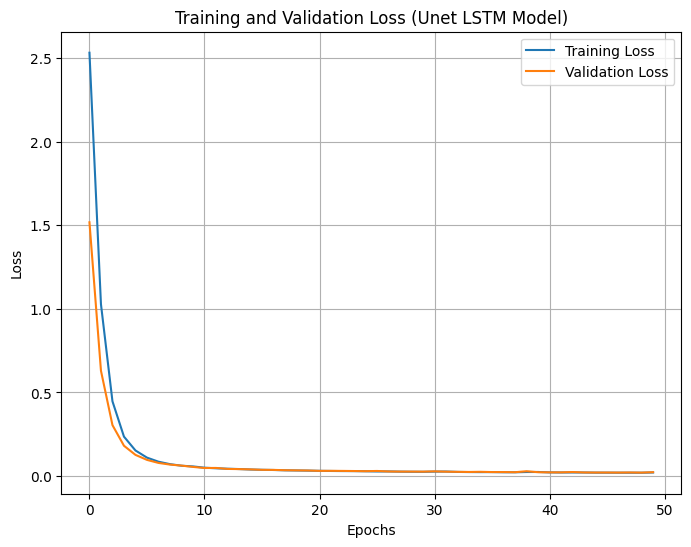

In [156]:
# Tracer la courbe de la loss
def plot_and_save_loss(history, filename='loss_plot_unet.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Unet LSTM Model)')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)  # Enregistrer le graphe
    plt.show()

# Après l'entraînement
plot_and_save_loss(history)

In [157]:
# Sauvegarder le modèle après l'entraînement
autoencoder_unet.save('lstm_unet_autoencoder_model.h5')  # Sauvegarder le modèle dans un fichier .h5
print("Modèle Unet enregistré avec succès")

Modèle Unet enregistré avec succès


In [58]:
# Charger le modèle après l'entraînement
autoencoder_unet_loaded = tf.keras.models.load_model('lstm_unet_autoencoder_model.h5')  # Charger le modèle sauvegardé

# Vérifier la structure du modèle chargé
autoencoder_unet_loaded.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 359, 135)]   0           []                               
                                                                                                  
 lstm_14 (LSTM)                 (None, 359, 512)     1327104     ['input_5[0][0]']                
                                                                                                  
 lstm_15 (LSTM)                 (None, 359, 256)     787456      ['lstm_14[0][0]']                
                                                                                                  
 lstm_16 (LSTM)                 (None, 128)          197120      ['lstm_15[0][0]']                
                                                                                            

In [59]:
# Reconstruction des données anomalies avec le modèle
reconstructed_anomaly_data_unet = autoencoder_unet_loaded.predict(anomaly_data_reduced_normal)

2/2 [==============================] - 2s 91ms/step


In [160]:
# Fonction pour tracer les comparaisons entre les données originales, ground truths et les données reconstruites
def plot_comparison_with_reconstructed(anomalous_data, ground_truth, reconstructed_data, feature_names, ground_truth_names, sample_index=0):
    """
    Trace les comparaisons entre les données originales, leurs ground truths et les reconstructions.

    Paramètres:
    - anomalous_data (numpy.array): Données anormales originales (samples, timesteps, features).
    - ground_truth (numpy.array): Ground truths correspondants (samples, timesteps, 2).
    - reconstructed_data (numpy.array): Données reconstruites par le modèle (samples, timesteps, features).
    - feature_names (list): Noms des variables à tracer.
    - ground_truth_names (list): Noms des ground truths.
    - sample_index (int): Index de l'échantillon à tracer.
    """
    time_steps = np.arange(anomalous_data.shape[1])

    for i, feature_name in enumerate(feature_names):
        plt.figure(figsize=(10, 5))
        # Données originales
        plt.plot(time_steps, anomalous_data[sample_index, :, i], label=f"{feature_name} (Anomalous)", alpha=0.7)
        # Ground truths
        plt.plot(time_steps, ground_truth[sample_index, :, i], label=f"{ground_truth_names[i]} (Ground Truth)", alpha=0.7)
        # Données reconstruites
        plt.plot(time_steps, reconstructed_data[sample_index, :, i], label=f"{feature_name} (Reconstructed)", linestyle='dashed')

        plt.xlabel("Time Steps")
        plt.ylabel("Value")
        plt.title(f"Comparison: {feature_name}, Ground Truth, and Reconstructed")
        plt.legend()
        plt.grid(True)
        plt.show()


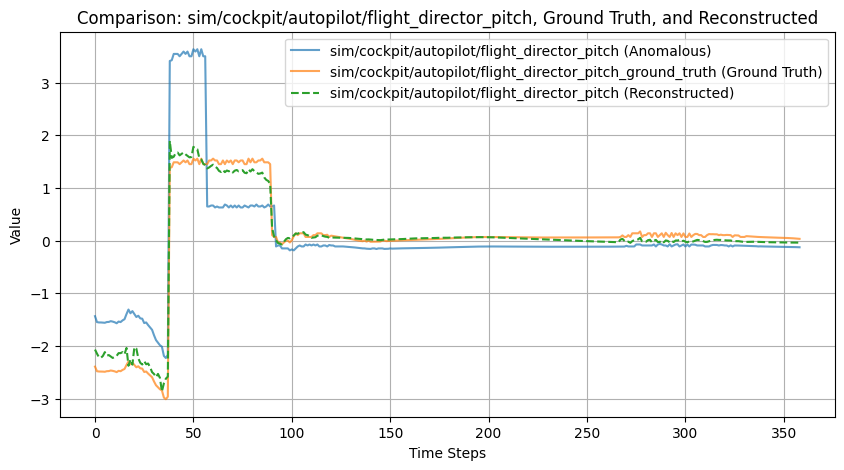

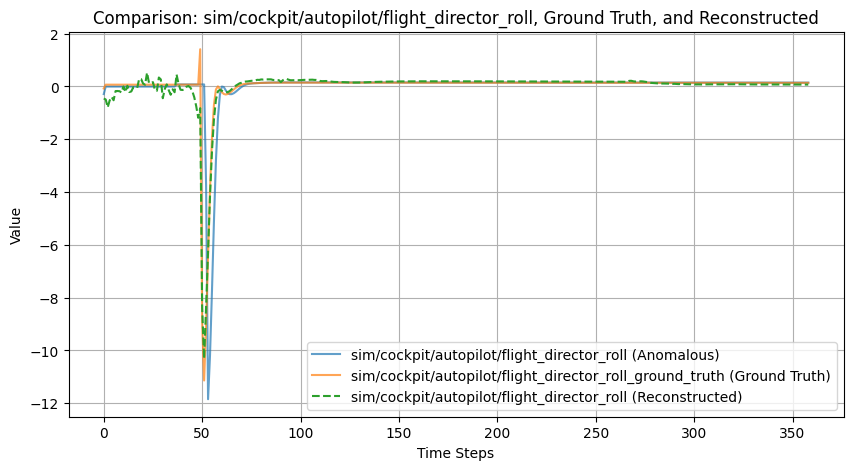

In [62]:
# Tracer les comparaisons pour le premier échantillon
plot_comparison_with_reconstructed(
    anomaly_data_reduced_normal, 
    anomaly_data_ground_truth, 
    reconstructed_anomaly_data_unet, 
    columns_anomalies, 
    columns_ground_truth, 
    sample_index=15  # Changer l'index pour examiner d'autres exemples
)

In [52]:
# Calculer l'erreur de reconstruction pour les données normales (train data)
reconstructed_normal = autoencoder_unet_loaded.predict(train_normal_data_reduced)
mse_normal = np.mean(np.square(train_normal_data_reduced - reconstructed_normal), axis=(1, 2))

24/24 [==============================] - 3s 113ms/step


In [94]:
# Déterminer un seuil pour détecter les anomalies à partir des données normales
threshold = np.percentile(mse_normal, 95)  # Utiliser le percentile 95 de l'erreur pour le seuil 
print(f"Seuil de détection des anomalies basé sur les données normales: {threshold}")

Seuil de détection des anomalies basé sur les données normales: 0.018170168741689252


In [95]:
# Calculer l'erreur de reconstruction pour les données anormales
reconstructed_anomalies = autoencoder_unet_loaded.predict(anomaly_data_reduced_normal)
mse_anomalies = np.mean(np.square(anomaly_data_reduced_normal - reconstructed_anomalies), axis=(1, 2))

2/2 [==============================] - 0s 274ms/step


In [96]:
# Détection des anomalies: Comparer l'erreur de reconstruction avec le seuil
anomalies = mse_anomalies > threshold  # Si l'erreur de reconstruction est plus grande que le seuil, c'est une anomalie
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

Nombre d'anomalies détectées: 7


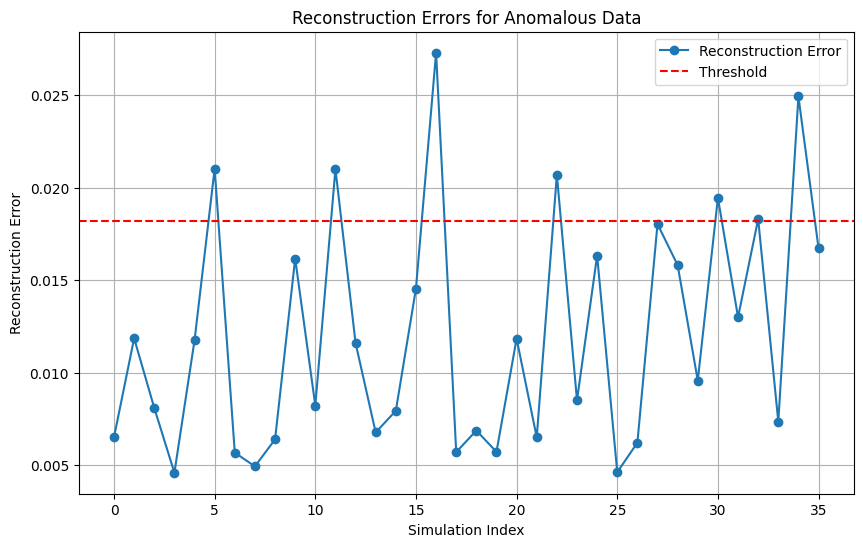

In [97]:
# Tracer l'erreur de reconstruction pour chaque simulation avec le seuil
def plot_reconstruction_errors(errors, threshold, title='Reconstruction Errors with Threshold'):
    plt.figure(figsize=(10, 6))
    plt.plot(errors, marker='o', linestyle='-', label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Simulation Index')
    plt.ylabel('Reconstruction Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Tracer les erreurs pour les données anormales
plot_reconstruction_errors(mse_anomalies, threshold, title='Reconstruction Errors for Anomalous Data')

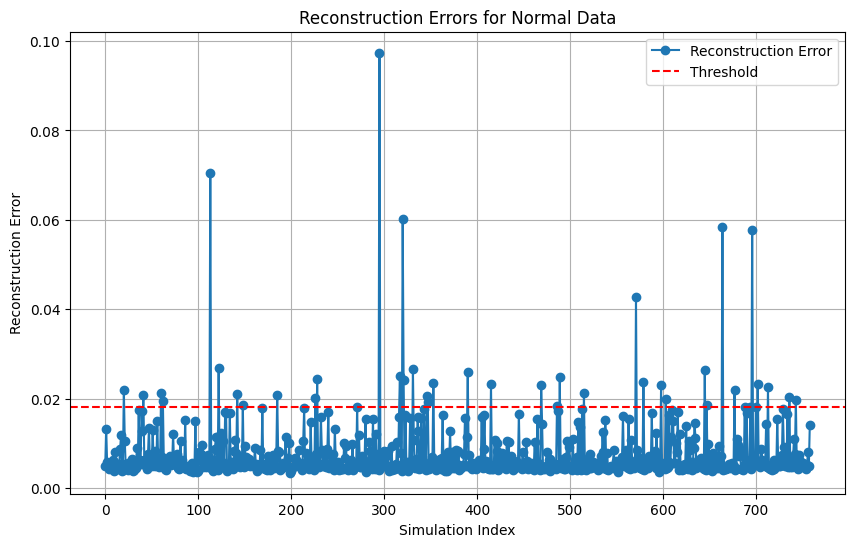

In [98]:
# Tracer l'erreur de reconstruction pour chaque simulation avec le seuil
def plot_reconstruction_errors(errors, threshold, title='Reconstruction Errors with Threshold'):
    plt.figure(figsize=(10, 6))
    plt.plot(errors, marker='o', linestyle='-', label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    plt.xlabel('Simulation Index')
    plt.ylabel('Reconstruction Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Tracer les erreurs pour les données anormales
plot_reconstruction_errors(mse_normal , threshold, title='Reconstruction Errors for Normal Data')

In [99]:
# Calculer l'erreur de reconstruction pour les données de test normales
reconstructed_test_normal = autoencoder_loaded.predict(test_normal_data_reduced)
mse_test_normal = np.mean(np.square(test_normal_data_reduced - reconstructed_test_normal), axis=(1, 2))

6/6 [==============================] - 1s 103ms/step


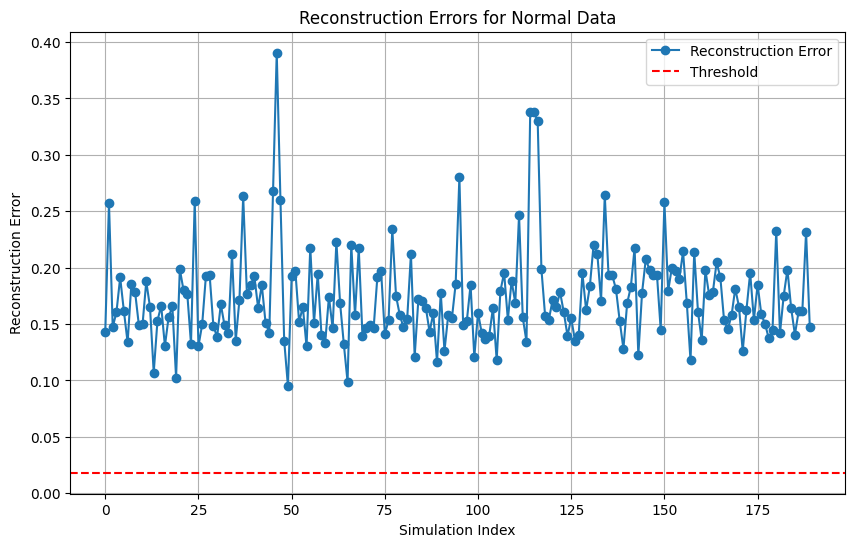

In [100]:
# Tracer les erreurs pour les données normales
plot_reconstruction_errors(mse_test_normal, threshold, title='Reconstruction Errors for Normal Data')

### Transformer autoencoder

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [38]:
# Transformer Encoder Layer
def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization()(attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    encoder_output = Add()([attention_output, ff_output])  # Residual connection
    encoder_output = LayerNormalization()(encoder_output)

    return encoder_output

# Transformer Decoder Layer
def transformer_decoder(inputs, encoder_outputs, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head attention over encoder outputs
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, encoder_outputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    attention_output = LayerNormalization()(attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    decoder_output = Add()([attention_output, ff_output])  # Residual connection
    decoder_output = LayerNormalization()(decoder_output)

    return decoder_output


In [45]:
# Dimensions des données
timesteps = train_normal_data_reduced.shape[1]
input_dim = train_normal_data_reduced.shape[2]
num_heads = 4
ff_dim = 128

# Inputs
inputs = Input(shape=(timesteps, input_dim))

# Encoder
encoder_output = transformer_encoder(inputs, num_heads=num_heads, ff_dim=ff_dim)

# Bottleneck
bottleneck = Dense(64, activation='relu')(encoder_output)

# Decoder
decoder_input = Dense(input_dim)(bottleneck)  # Initialize decoder inputs
decoder_output = transformer_decoder(decoder_input, encoder_output, num_heads=num_heads, ff_dim=ff_dim)

# Reconstruction
outputs = Dense(input_dim)(decoder_output)

In [52]:
# Model
transformer_autoencoder = Model(inputs, outputs)
transformer_autoencoder.compile(optimizer='adam', loss='mse')
transformer_autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 359, 135)]   0           []                               
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 359, 135)    293355      ['input_5[0][0]',                
 eadAttention)                                                    'input_5[0][0]']                
                                                                                                  
 dropout_8 (Dropout)            (None, 359, 135)     0           ['multi_head_attention_4[0][0]'] 
                                                                                                  
 add_8 (Add)                    (None, 359, 135)     0           ['input_5[0][0]',          

In [47]:
# Train
history = transformer_autoencoder.fit(
    train_normal_data_reduced,
    train_normal_data_reduced,
    epochs=25,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/25
19/19 [==============================] - 4s 117ms/step - loss: 0.5534 - val_loss: 0.3216
Epoch 2/25
19/19 [==============================] - 2s 96ms/step - loss: 0.3109 - val_loss: 0.2134
Epoch 3/25
19/19 [==============================] - 2s 95ms/step - loss: 0.2275 - val_loss: 0.1784
Epoch 4/25
19/19 [==============================] - 2s 95ms/step - loss: 0.1887 - val_loss: 0.1506
Epoch 5/25
19/19 [==============================] - 2s 95ms/step - loss: 0.1650 - val_loss: 0.1332
Epoch 6/25
19/19 [==============================] - 2s 95ms/step - loss: 0.1472 - val_loss: 0.1235
Epoch 7/25
19/19 [==============================] - 2s 96ms/step - loss: 0.1359 - val_loss: 0.1130
Epoch 8/25
19/19 [==============================] - 2s 96ms/step - loss: 0.1249 - val_loss: 0.1053
Epoch 9/25
19/19 [==============================] - 2s 95ms/step - loss: 0.1171 - val_loss: 0.1003
Epoch 10/25
19/19 [==============================] - 2s 95ms/step - loss: 0.1103 - val_loss: 0.0941
Epoch 11

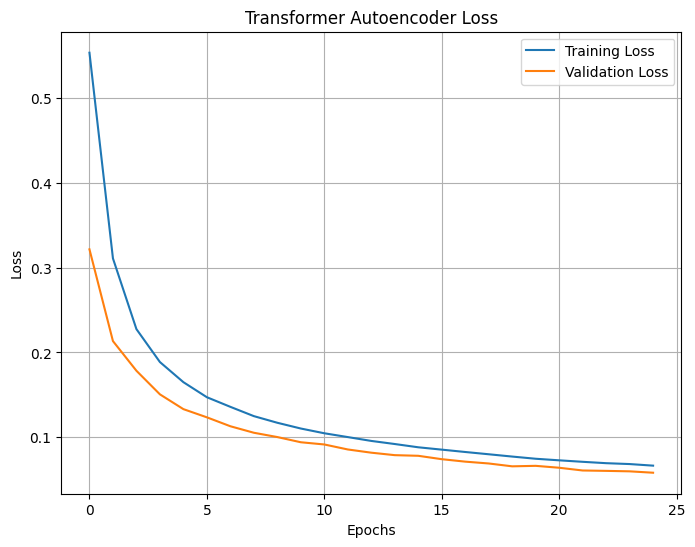

In [48]:
# Plot loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Transformer Autoencoder Loss')
    plt.grid()
    plt.show()

plot_loss(history)

2/2 [==============================] - 0s 11ms/step


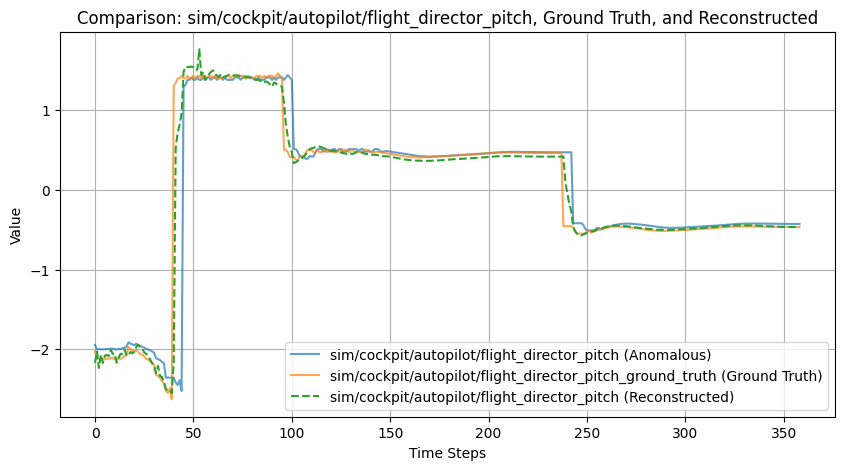

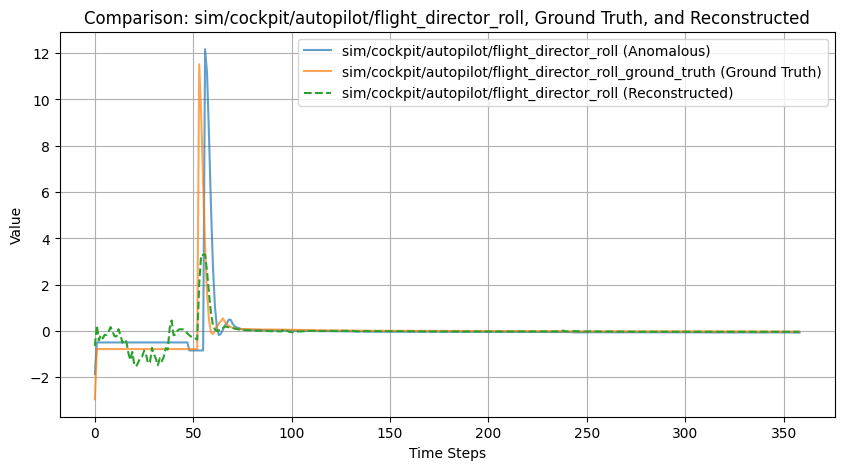

In [51]:
# Reconstruction des données anomalies avec le modèle Transformer
reconstructed_anomaly_transformer = transformer_autoencoder.predict(anomaly_data_reduced_normal)

# Tracer les comparaisons pour le premier échantillon (Transformer)
plot_comparison_with_reconstructed(
    anomaly_data_reduced_normal, 
    anomaly_data_ground_truth, 
    reconstructed_anomaly_transformer,  # Données reconstruites par le modèle Transformer
    columns_anomalies, 
    columns_ground_truth, 
    sample_index=30  # Changer l'index pour examiner d'autres exemples
)

In [110]:
# Calculer l'erreur de reconstruction pour les données normales (train data)
reconstructed_normal = transformer_autoencoder.predict(train_normal_data_reduced)
mse_normal = np.mean(np.square(train_normal_data_reduced - reconstructed_normal), axis=(1, 2))

# Déterminer un seuil pour détecter les anomalies à partir des données normales
threshold = np.percentile(mse_normal, 95)  # Utiliser le percentile 95 de l'erreur pour le seuil 
print(f"Seuil de détection des anomalies basé sur les données normales: {threshold}")



24/24 [==============================] - 1s 35ms/step
Seuil de détection des anomalies basé sur les données normales: 0.10152459214768644


In [111]:
# Calculer l'erreur de reconstruction pour les données de test normales
reconstructed_test_normal = transformer_autoencoder.predict(test_normal_data_reduced)
mse_test_normal = np.mean(np.square(test_normal_data_reduced - reconstructed_test_normal), axis=(1, 2))

# Calculer l'erreur de reconstruction pour les données anormales
reconstructed_anomalies = transformer_autoencoder.predict(anomaly_data_reduced_normal)
mse_anomalies = np.mean(np.square(anomaly_data_reduced_normal - reconstructed_anomalies), axis=(1, 2))

# Détection des anomalies: Comparer l'erreur de reconstruction avec le seuil
anomalies = mse_anomalies > threshold  # Si l'erreur de reconstruction est plus grande que le seuil, c'est une anomalie
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

2/2 [==============================] - 0s 11ms/step
Nombre d'anomalies détectées: 2


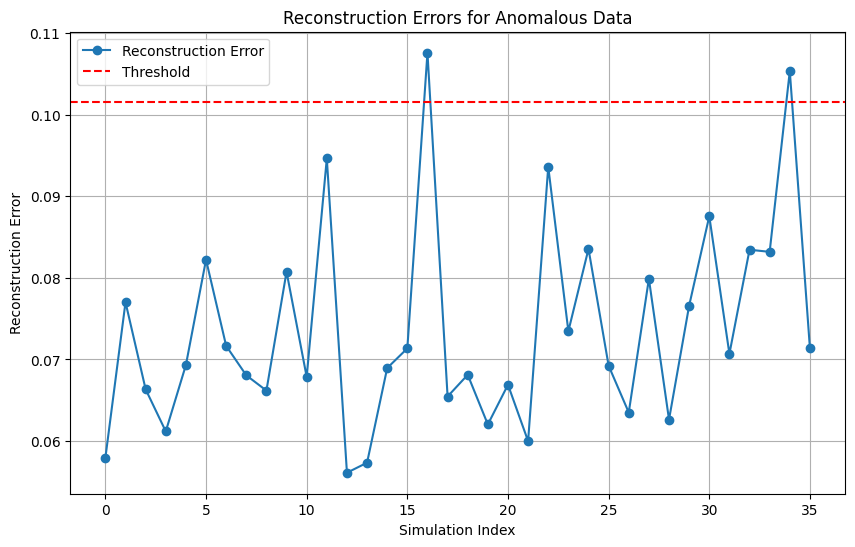

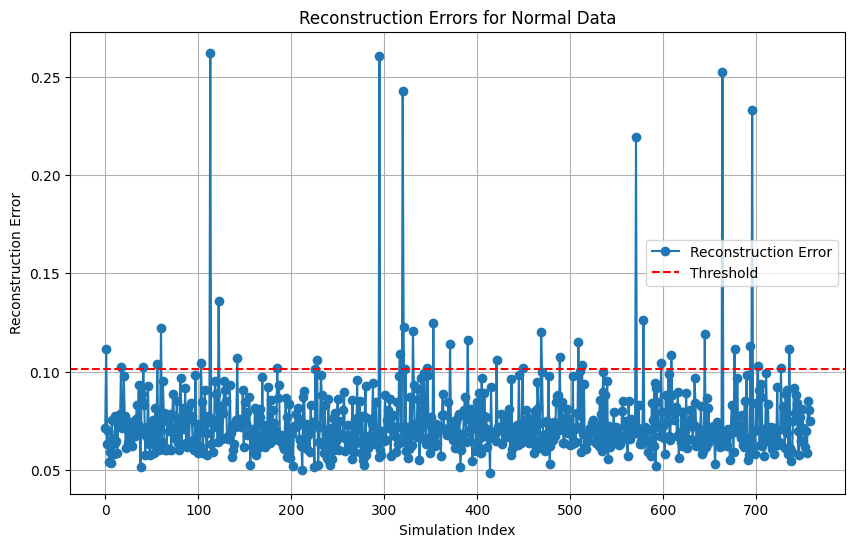

In [112]:
# Tracer les erreurs pour les données anormales
plot_reconstruction_errors(mse_anomalies, threshold, title='Reconstruction Errors for Anomalous Data')

# Tracer les erreurs pour les données normales
plot_reconstruction_errors(mse_normal, threshold, title='Reconstruction Errors for Normal Data')